# Pre-operative Imaging Concordance Analysis

This notebook evaluates how well each imaging modality predicts surgical findings in parathyroid disease.

### **Key Terms**

- **Modality:** Imaging type (e.g. SPECT/CT, 4D CT, Ultrasound, Sestamibi, MRI).
- **Concordance Categories:**
  - **Yes (Exact):** All surgical glands matched.
  - **Yes (Partial):** Some glands matched, or side match in multi-gland disease.
  - **Yes (Side):** Side matches without gland match (single-gland disease).
  - **Incorrect Localization:** No gland or side match, or hyperplasia.
  - **Non-localizing:** Imaging failed to localize.
  - **No Scan:** Scan not performed.
  - **Unknown:** Missing data.

### **Notebook Sections**

1. **Concordance Analysis:** Calculates match rates by modality.
2. **Localization Summary:** Counts localizing vs. non-localizing scans and calculates non-localization rates.

This overview ensures clarity on terminology and analysis structure.

---

## Concordance Analysis

Calculates how well each imaging modality's findings match surgical findings, categorized as Exact, Partial, Side, or Incorrect Localization.

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('../../Data/final_imaging_data.xlsx')

In [ ]:
def check_concordance(row, modality_col):
    """
    Determines concordance between imaging modality findings and surgical findings.

    Parameters:
        row (pd.Series): A row from the dataframe containing imaging and surgical data.
        modality_col (str): The column name of the imaging modality to evaluate.

    Returns:
        str: Concordance category, one of:
            - 'Yes (Exact)'
            - 'Yes (Partial)'
            - 'Yes (Side)'
            - 'Incorrect Localization'
            - 'Non-localizing'
            - 'No Scan'
            - 'Unknown'
    """
    imaging = row[modality_col]
    surgical = row['Surgical Findings']

    # Return Unknown if imaging or surgical data is missing
    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'

    # Handle No Scan and Non-localizing 
    if imaging == 'No Scan':
        return 'No Scan'
    if imaging == 'Non-localizing':
        return 'Non-localizing'

    # If surgery found 4 gland hyperplasia, any single imaging finding is incorrect
    if 'hyperplasia' in surgical.lower():
        return 'Incorrect Localization'

    # Split and clean imaging and surgical gland strings into sets
    imaging_glands = [g.strip().lower() for g in imaging.split(',')]
    surgical_glands = [g.strip().lower() for g in surgical.split(',')]
    imaging_set = set(imaging_glands)
    surgical_set = set(surgical_glands)

    # Exact match: all surgical glands found in imaging
    if surgical_set.issubset(imaging_set):
        return 'Yes (Exact)'

    # Partial match: at least one gland match
    if imaging_set & surgical_set:
        return 'Yes (Partial)'

    # Side match analysis
    imaging_sides = ['left' for ig in imaging_glands if 'left' in ig] + \
                    ['right' for ig in imaging_glands if 'right' in ig]
    surgical_sides = ['left' for sg in surgical_glands if 'left' in sg] + \
                     ['right' for sg in surgical_glands if 'right' in sg]
    
    # Multi-gland surgery with side match → Partial
    if any(side in surgical_sides for side in imaging_sides):
        if len(surgical_glands) > 1:
            return 'Yes (Partial)'
        else:
            # Single gland surgery with side match = Side match
            return 'Yes (Side)'
    return 'Incorrect Localization'

In [44]:
# Calculate Concordance for Each Modality
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

# Apply the check_concordance function to each modality
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    
    # Calculate concordance for each row and store in a new column
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(
        lambda row: check_concordance(row, modality), axis=1
    )

# Initialize summary data list
summary_data = []

# Loop through modalities and collect counts + percentages
for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'
    
    # Filter to localizing rows only
    localizing_df = preop_imaging_df[
        ~preop_imaging_df[concordance_col].isin(['Unknown', 'Non-localizing'])
    ].copy()
    
    # Calculate value counts and total count
    counts = localizing_df[concordance_col].value_counts()
    total = counts.sum()
    
    for match_type, count in counts.items():
        pct = round((count / total) * 100 if total > 0 else 0, 2)
        
        # Append results as dictionaries to summary_data list
        summary_data.append({
            'Modality': modality,
            'Concordance': match_type,
            'Count': count,
            'Percentage': pct
        })

In [45]:
# Convert to DataFrame
concordance_summary_df = pd.DataFrame(summary_data)

# Pivot for grouped bar plot preparation (optional)
pivot_df = concordance_summary_df.pivot(index='Modality', columns='Concordance', values='Percentage').fillna(0)

# Reorder columns 
ordered_cols = ['Yes (Exact)', 'Yes (Side)', 'Incorrect Localization']
pivot_df = pivot_df.reindex(columns=ordered_cols).fillna(0)

# Display results
display(concordance_summary_df)
display(pivot_df)

,Modality,Concordance,Count,Percentage
0,SPECT/CT,Yes (Exact),72,40.45
1,SPECT/CT,Yes (Side),67,37.64
2,SPECT/CT,Yes (Partial),24,13.48
3,SPECT/CT,Incorrect Localization,15,8.43
4,4D CT Scan,Yes (Exact),78,45.09
5,4D CT Scan,Yes (Side),47,27.17
6,4D CT Scan,Incorrect Localization,27,15.61
7,4D CT Scan,Yes (Partial),21,12.14
8,Ultrasound,Yes (Side),32,41.03
9,Ultrasound,Yes (Exact),26,33.33


Concordance,Yes (Exact),Yes (Side),Incorrect Localization
Modality,,,
4D CT Scan,45.09,27.17,15.61
MRI,50.00,25.00,25.00
SPECT/CT,40.45,37.64,8.43
Sestamibi,40.71,51.33,0.88
Ultrasound,33.33,41.03,14.10


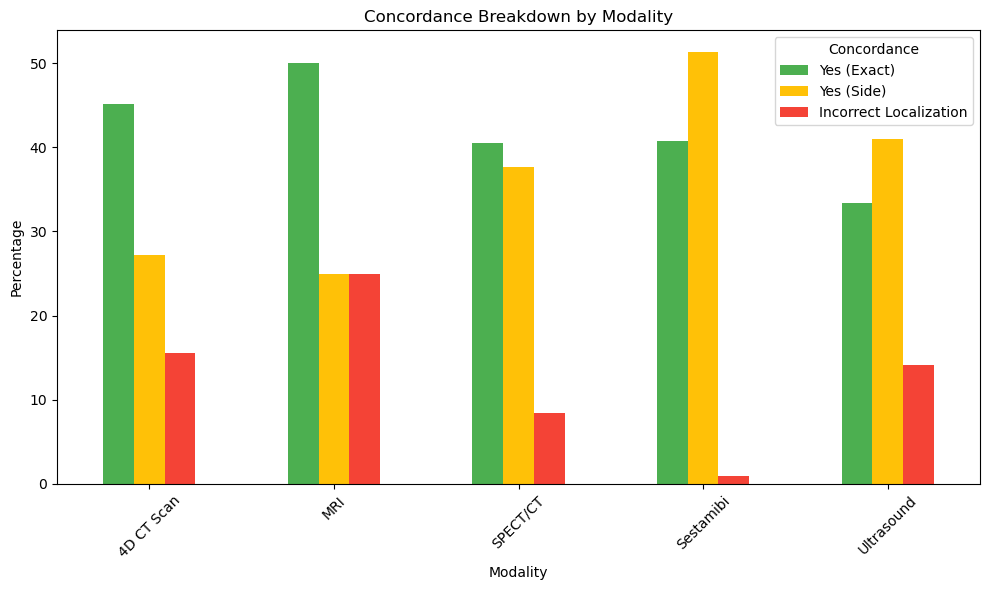

In [46]:
# Plot grouped bar plot
pivot_df.plot(
    kind='bar',
    figsize=(10,6),
    color=['#4CAF50', '#FFC107', '#F44336']  # green, yellow, red
)

plt.ylabel('Percentage')
plt.title('Concordance Breakdown by Modality')
plt.xticks(rotation=45)
plt.legend(title='Concordance')
plt.tight_layout()
plt.show()

## Localization vs Non-localization Summary

Summarizes the number and rate of scans that localized versus those that failed to localize for each imaging modality.

In [47]:
# Initialize dictionaries to store results
non_localizing_counts = {}      # Number of non-localizing scans
localizing_counts = {}          # Number of localizing scans
non_localization_rates = {}     # Percentage of non-localizing scans
localization_rates = {}         # Percentage of localizing scans


for modality in modalities:
    # Count non-localizing
    non_localizing_count = preop_imaging_df[preop_imaging_df[modality] == 'Non-localizing'].shape[0]
    non_localizing_counts[modality] = non_localizing_count

    # Count localizing (not Non-localizing and not NaN)
    localizing_count = preop_imaging_df[
        preop_imaging_df[modality].notnull() & 
        (preop_imaging_df[modality] != 'Non-localizing') & 
        (preop_imaging_df[modality] != 'No Scan')
    ].shape[0]
    localizing_counts[modality] = localizing_count

    # Calculate total scans with data
    total = non_localizing_count + localizing_count

    # Calculate non-localization rate
    non_localization_rates[modality] = round((non_localizing_count / total * 100) if total > 0 else 0, 2)
    localization_rates[modality] = round((localizing_count / total * 100) if total > 0 else 0, 2)


# Convert to DataFrame
summary_df = pd.DataFrame({
    'Non-localizing': pd.Series(non_localizing_counts),
    'Localizing': pd.Series(localizing_counts),
    'Non-localization Rate (%)': pd.Series(non_localization_rates),
    'Localization Rate (%)': pd.Series(localization_rates)
})

display(summary_df)

,Non-localizing,Localizing,Non-localization Rate (%),Localization Rate (%)
SPECT/CT,52,178,22.61,77.39
4D CT Scan,55,173,24.12,75.88
Ultrasound,67,78,46.21,53.79
Sestamibi,61,113,35.06,64.94
MRI,7,8,46.67,53.33


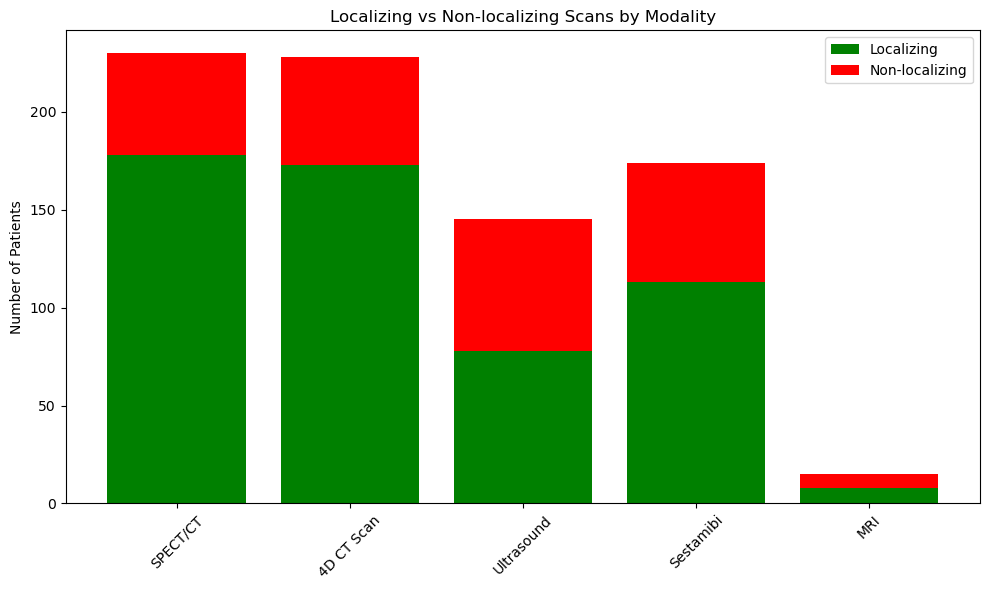

In [48]:
# Convert to Series
localizing_series = pd.Series(localizing_counts)
non_localizing_series = pd.Series(non_localizing_counts)

modalities = localizing_series.index.tolist()

plt.figure(figsize=(10,6))

# Bar plots with .values for y-axis heights
plt.bar(modalities, localizing_series.values, label='Localizing', color='green')
plt.bar(modalities, non_localizing_series.values, bottom=localizing_series.values, label='Non-localizing', color='red')

plt.ylabel('Number of Patients')
plt.title('Localizing vs Non-localizing Scans by Modality')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()